In [1]:
import numpy as np
import scipy as sp
import pylab as pl
import itertools
pl.rcParams['figure.figsize'] = 4,4

from gmm_base import *
from simulation import *

In [2]:
background = 0.2
base = 2
lamb = lambda t: background + base**-t
cond = 1
xmax = 3
bins = np.linspace(0, 10, 201)
sample_size = int(1e4)
num_clusters = 20

### data generation

In [3]:
x = np.array([thinning_sampler(rng, lamb) for rng in
              itertools.repeat(np.random.RandomState(0), sample_size)])

(0, 3)

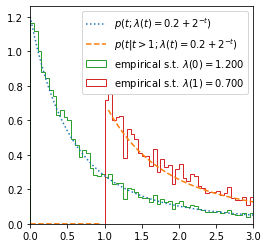

In [4]:
pl.plot(bins, lamb(bins)*np.exp([
        -sp.integrate.quad(lamb, 0, x)[0] for x in bins
    ]), ls=':', label=f'$p(t;\lambda(t)={background}+{base}^{{-t}})$')

pl.plot(bins, np.where(
    bins<cond, 0,
    lamb(bins)*np.exp([
        -sp.integrate.quad(lamb, cond, x)[0] if x>cond else np.nan
        for x in bins
    ])
), ls='--', label=f'$p(t|t>{cond};\lambda(t)={background}+{base}^{{-t}})$')

pl.hist(x, bins, density=True, fill=False, histtype='step',
        label=f'empirical s.t. $\lambda(0)={lamb(0):.3f}$');

pl.hist(x[x>cond], bins, density=True, fill=False, histtype='step',
        label=f'empirical s.t. $\lambda({cond})={lamb(cond):.3f}$');

pl.legend(loc='upper right')
pl.xlim(xmin=0, xmax=xmax)

# fit GMM

In [5]:
model = GMMModel(x[:,None], num_clusters=num_clusters)
trainer = GMMTrainer(model)

for t,epoch in elapsed(range(100)):
    trainer(x[:,None])
    if np.allclose(np.log2(epoch+1), np.round(np.log2(epoch+1))) or epoch+1==100:
        loglik = model(mx.nd.array(x[:,None]))[0].mean().asscalar()
        print(f'{epoch+1} loglik={loglik:.3f} elapsed={t:.1f}s')

1 loglik=-2.531 elapsed=0.0s
2 loglik=-2.225 elapsed=0.2s
4 loglik=-1.799 elapsed=0.5s
8 loglik=-1.577 elapsed=0.9s
16 loglik=-1.495 elapsed=1.8s
32 loglik=-1.467 elapsed=3.5s
64 loglik=-1.458 elapsed=6.8s
100 loglik=-1.452 elapsed=10.4s


In [6]:
lamb0 = infer_lambda(model, xmin=0, xmax=1)
lamb1 = infer_lambda(model, xmin=cond, xmax=cond+1)
print(f'inferred lamb(0)={lamb0:.3f}, lamb({cond})={lamb1:.3f}')

inferred lamb(0)=1.366, lamb(1)=0.908


In [7]:
def mixture_pdf(bins):
    log_marg = model(mx.nd.array(bins, dtype='float32'))[0]
    return log_marg.exp().asnumpy()

(0, 1.3621529662981628)

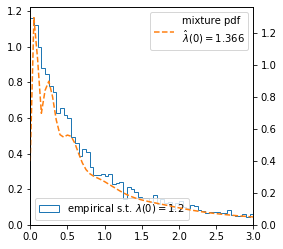

In [8]:
pl.hist(x, bins, density=True, fill=False, histtype='step',
        label=f'empirical s.t. $\lambda(0)={lamb(0)}$')
pl.legend(loc='lower left')
pl.xlim(xmin=0, xmax=xmax)
pl.twinx()

pl.plot(bins, mixture_pdf(bins[:,None]),
        '--', color='C1',
        label=f'mixture pdf\n$\hat\lambda(0)={lamb0:.3f}$')
pl.legend(loc='upper right')
pl.ylim(ymin=0)

(0, 0.28398601412773133)

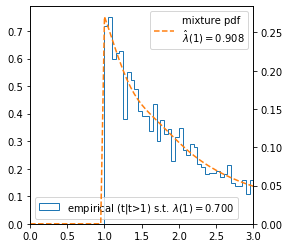

In [9]:
pl.hist(x[x>cond], bins, density=True, fill=False, histtype='step',
        label=f'empirical (t|t>{cond}) s.t. $\lambda({cond})={lamb(cond):.3f}$');
pl.legend(loc='lower left')
pl.xlim(xmin=0, xmax=xmax)
pl.twinx()

pl.plot(bins, np.where(bins<cond, 0, mixture_pdf(bins[:,None])),
        '--', color='C1',
        label=f'mixture pdf\n$\hat\lambda({cond})={lamb1:.3f}$')
pl.legend(loc='upper right')
pl.ylim(ymin=0)

### The main bias in the estimation is due to lamb'(t), independent of GMM

In [10]:
for interval in [(0,1),(1,2),(2,3)]:
    true_poly = np.polyfit(
        np.linspace(*interval),
        [np.log(lamb(b)) - sp.integrate.quad(lamb, 0, b)[0]
         for b in np.linspace(*interval)],
        1
    )
    gmm_poly = np.polyfit(
        np.linspace(*interval),
        model(mx.nd.array(np.linspace(*interval))[:,None])[0].asnumpy(),
        1
    )
    print(f'{interval} '
          f'lamb({interval[0]})={lamb(interval[0]):.3f} '
          f'true_neg_slope={-true_poly[0]:.3f} '
          f'gmm_neg_slope={-gmm_poly[0]:.3f}')

(0, 1) lamb(0)=1.200 true_neg_slope=1.455 gmm_neg_slope=1.366
(1, 2) lamb(1)=0.700 true_neg_slope=1.000 gmm_neg_slope=0.908
(2, 3) lamb(2)=0.450 true_neg_slope=0.704 gmm_neg_slope=0.774
